Scope:

This branch should implement torch functionality in expsolve. 

Once investigations are done, the derivative part needs to go in fourier and splittings, for e.g., to make torch compatible derivatives, and this file should be deleted. 

Torch compatible applications should be in their own specific branches and not included here. 

# Hamiltonian Identification

In [41]:
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.splittings.classical as split
import expsolve.fourier as ex

import torch
from torch import exp, sin, abs, real, imag, pi, diag
from torch.linalg import matrix_exp

True Potential

In [42]:
def quarticpoly(c):
    return c[4] * (x**4) + c[3] * (x**3) + c[2] * (x**2) + c[1] * x + c[0] * torch.ones(x.size())

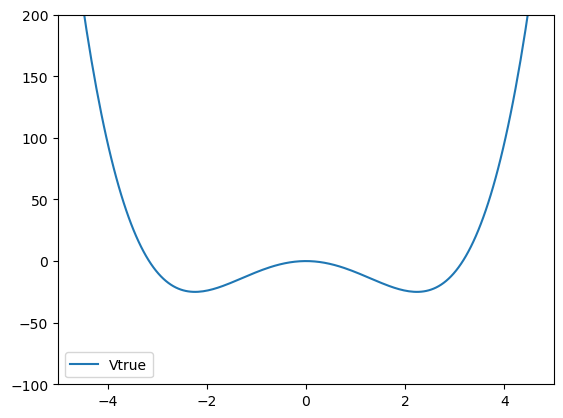

In [43]:
n = 400
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

ctrue = torch.tensor([0., 0., -10., 0., 1.], dtype = torch.float64)
Vtrue = quarticpoly(ctrue)

plt.xlim(-5,5)
plt.ylim(-100,200)

plt.plot(x, Vtrue)

plt.legend(['Vtrue'])
plt.show()

Solvers

In [44]:
T = 0.1
N = 100

eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda V: lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
blanesmoanstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, blanesmoanalpha, blanesmoanbeta)

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)
strangstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, strangalpha, strangbeta)


solver = lambda V, u: es.evolve(u, es.timegrid(T, N), strangstep(V) )[0]

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


Polynomial Ansatz

Dataset

In [45]:
def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))
    u = ex.normalize(u, xr)
    return u


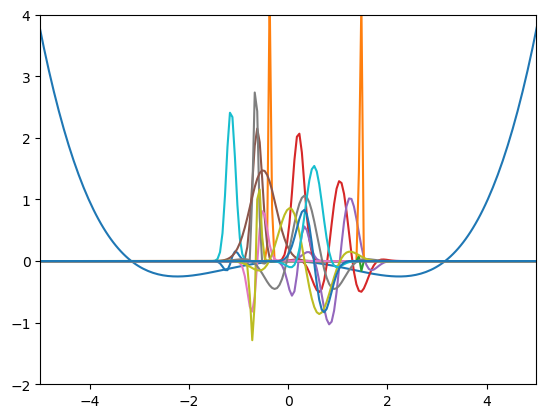

In [46]:
plt.xlim(-5,5)
plt.ylim(-2,4)

plt.plot(x, Vtrue/100)

for i in range(10):
    u0 = ugen(sx0=1.0, svar=0.3, sw0=1.5)
    plt.plot(x, real(u0))
    plt.plot(x, imag(u0))

plt.show()

In [75]:
nrm = lambda v: real( sum(v.conj() * v) )
lossfn = lambda V, u: nrm(solver(V, u) - solver(Vtrue, u) )
#lossfn = lambda V, u: ex.l2norm(solver(V, u) - solver(Vtrue, u) )**2


In [80]:
def loss_batch_with_fd(coeff, nbatch):
    loss = torch.tensor(0., dtype=torch.float64)
    fdgrad = torch.tensor([0., 0., 0., 0., 0.], dtype=torch.float64)

    for i in range(nbatch):
        u = ugen(sx0=1.0, svar=0.3, sw0=1.5)
        L = lossfn(quarticpoly(coeff), u)
        loss += L

        # finite difference grads for debug - seem OK!
        with torch.no_grad():
            s = 1e-6
            I = np.eye(5)
            for i in range(5):
                e = torch.tensor(I[i,:], dtype=torch.float64)
                Ve = quarticpoly(coeff + s*e)
                Le = lossfn(Ve, u)
                fdgrad[i] += (Le-L)/s
        
    return loss, fdgrad

In [81]:
coeff = torch.tensor([0., 0., 0., 0., 1.], dtype = torch.float64, requires_grad=True)
coeff

tensor([0., 0., 0., 0., 1.], dtype=torch.float64, requires_grad=True)

In [82]:
loss_batch_with_fd(coeff, 10)

(tensor(286.1292, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([ 10.4083,   5.8842,   0.8080,  21.0481, -28.9628], dtype=torch.float64))

In [83]:
optimizer = torch.optim.SGD([coeff], lr=0.01)
num_steps = 10


for step in range(num_steps):
    # Compute the loss
    # loss = loss_batch(coeff, 10)
    loss, fdgrad = loss_batch_with_fd(coeff, 10)
    
    cstr = np.array2string(coeff.detach().numpy(), precision=2, separator=', ')
    print(f'At step {step}, loss is {loss}, coeff is {cstr}')

    # Zero the gradients to prevent accumulation
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()
    print(coeff.grad)
    print(fdgrad)

    # Update parameters using the gradients
    optimizer.step()


cstr = np.array2string(coeff.detach().numpy(), precision=2, separator=', ')
print(f'At step {step}, loss is {loss}, coeff is {cstr}')

At step 0, loss is 328.0064877366053, coeff is [0., 0., 0., 0., 1.]
tensor([  5.6406,  -4.4959,  -2.6542, -48.4341, -63.4306], dtype=torch.float64)
tensor([  5.6406,  -4.4959,  -2.6542, -48.4342, -63.4359], dtype=torch.float64)
At step 1, loss is 241.77921699761288, coeff is [-0.06,  0.04,  0.03,  0.48,  1.63]
tensor([14.0164, -7.5131, 10.2068, -6.6795,  0.2083], dtype=torch.float64)
tensor([13.9937, -7.5131, 10.2068, -6.6795,  0.2081], dtype=torch.float64)


KeyboardInterrupt: 

Maybe the quartic paramterization is very difficult to learn

In [138]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 6),   # Fully connected layer 1 with 1 input and 32 output neurons
            nn.ReLU(),          # ReLU activation function
            nn.Linear(6, 6),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ReLU(),          # ReLU activation function
            nn.Linear(6, 1)    # Fully connected layer 3 with 16 input neurons and 1 output neuron
        )
        self.model = self.model.double()    # double precision

    def forward(self, x):
        return x**4 + torch.tensor([self.model(torch.tensor([a])) for a in x], dtype=torch.float64)
    
# Create an instance of the SimpleNN model
model = SimpleNN()

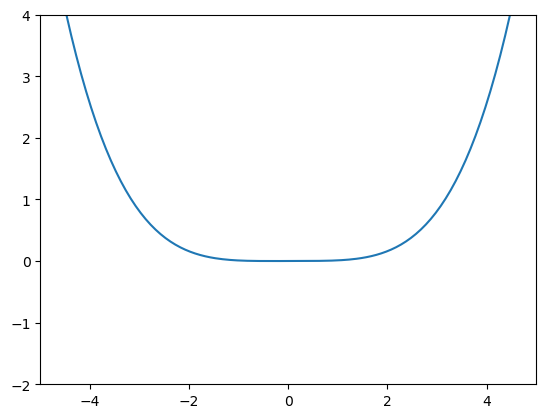

In [139]:
plt.plot(x, model(x)/100)
plt.xlim(-5,5)
plt.ylim(-2,4)

plt.show()

In [140]:
def loss_batch(V, nbatch):
    loss = torch.tensor(0., dtype=torch.float64)

    for i in range(nbatch):
        u = ugen(sx0=1.0, svar=0.3, sw0=1.5)
        L = lossfn(V, u)
        loss += L
        
    return loss

In [141]:
V = model(x)
V.requires_grad

False

In [144]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #, dtype=torch.double)
num_steps = 10


for step in range(num_steps):
    # Compute the loss
    V = model(x)
    V.requires_grad_()
    loss = loss_batch(V, 10)
    
    print(f'At step {step}, loss is {loss}')

    # Zero the gradients to prevent accumulation
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    #plt.plot(x, V.detach().numpy()/100)
    #plt.xlim(-5,5)
    #plt.ylim(-2,4)
    
    #plt.show()

    # Update parameters using the gradients
    optimizer.step()


cstr = np.array2string(coeff.detach().numpy(), precision=2, separator=', ')
print(f'At step {step}, loss is {loss}')

At step 0, loss is 276.9048909529981
At step 1, loss is 249.42198843736264
At step 2, loss is 247.4150391595357
At step 3, loss is 211.98705199101911
At step 4, loss is 187.4715940167349
At step 5, loss is 251.57731663088015
At step 6, loss is 316.223243287358
At step 7, loss is 325.37264923287387
At step 8, loss is 162.38163636875015
At step 9, loss is 179.27913575069647
At step 9, loss is 179.27913575069647
